<a href="https://www.kaggle.com/code/joshuacurtiswebb/spx-option-backtester?scriptVersionId=129838483" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import logging
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
from time import perf_counter
import spx_strategies as ss
import optuna
import os
from shutil import copy
from textwrap import wrap
pd.set_option("max_columns", 200)

#copy db
cwd = os.getcwd()
output_spx_spread_backtester_path = '/kaggle/input/spx-option-spread-backtester/'
dir_list = os.listdir(output_spx_spread_backtester_path)
files = [f for f in dir_list if os.path.isfile(output_spx_spread_backtester_path+f) and ".db" in f] #Filtering only the db files.
for f in files:
    if not os.path.exists(cwd+'/'+f):
        print(f"Copying db file to output : {f}")
        copy(output_spx_spread_backtester_path+f,cwd+'/'+f)



#########################
# Settings for backtest #
#########################
# Delta values must be scaled from 0.0 to 1.0 (0 delta to 100 delta)
delta_sp = 0.214
delta_lp = 0.001
delta_sc = 0.201
delta_lc = 0.001
delta_params = {'delta_sp':delta_sp, 'delta_lp':delta_lp, 'delta_sc':delta_sc,'delta_lc':delta_lc}

same_day = False
purchase_time = '15:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 100

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0


files = [
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2020_0dte_all.csv", 
#     f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", 
#    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_0dte_all.csv"
   # f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_1545_1600.csv",
    f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2022_1545_1600.csv"
]
li = []
for f in files:   
    df = pd.read_csv(f, index_col=None, header=0, dtype={'type':'category','quote_time':'category'})
    li.append(df)
    
df = pd.concat(li, axis=0, ignore_index=True)
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()

if 'dte' not in df:
    df['dte'] = ((df['expiration'] - df['quote_date']) / np.timedelta64(1, 'D')).astype('int')

initial_portfolio_value = df.loc[1,'price']*20

df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

Copying db file to output : optimal-iron-condor-study_2022_1.db
Copying db file to output : optimal-iron-condor-study.db


# New strategy schema focused on static and dynamic entry and exit policies

This code will be moved to a plugin notebook after it is stable

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from abc import ABC, abstractmethod

class AbstractStrategy:
    def __init__(self, entry_policy, exit_policy, df_ty, initial_portfolio_value, commission = 1.5, debug = False):
        self.entry_policy = entry_policy
        self.exit_policy = exit_policy
        self.commission = commission
        self.initial_portfolio_value = initial_portfolio_value
        self.df_ty = df_ty
        self.debug = debug
        self.df_trades = None
       
    @abstractmethod
    def performCalcs(self):
        df_trades = self.df_trades
        df_trades['commission'] = df_trades['trade_count']*commission
        df_trades['lost'] = df_trades['lost_c_s'] + df_trades['lost_p_s']
        df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
        df_trades['portfolio_value'] = 0.0
        #df_trades['daily_return'] = 0.0
        #df_trades['margin_utilization']=0.0
        initial_portfolio_value = self.initial_portfolio_value
        df_trades['net_cumsum']=df_trades['net'].cumsum()

        df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
        df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
        net = df_trades['net'].iloc[0]
        df_trades.loc[0,'transaction_return'] = df_trades['net'].iloc[0] / initial_portfolio_value
        df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

        df_ty = self.df_ty.copy()
        df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
        df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

        df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
        df_trades.drop(['Date'],axis=1,inplace=True)

        # if you want to scale the chart, you should do it here
        factor = 1.0
        df_trade_plot = df_trades.copy()
        df_trade_plot['net'] = df_trade_plot['net']*factor
        df_trade_plot.set_index('expiration', inplace=True)
        df_trade_plot = df_trade_plot['net'].cumsum()
        
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        secax = ax.secondary_yaxis('right', functions=(self.net2pct, self.pct2net))
        secax.set_ylabel('% return')
        df_trade_plot.plot(ax=ax)
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"{str(self)}.png")
        if self.debug == False:
            plt.close(fig)

        df_trades_transaction_return = df_trades.copy()
        df_trades_transaction_return['transaction_return'] *= 100 
        df_trades_transaction_return.set_index('expiration', inplace=True)
        fig = plt.figure()
        ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
        ax.set_ylabel('Transaction Return %')
        plt.title("\n".join(wrap(str(self),50)))
        plt.grid()
        plt.savefig(f"daily_ret_{str(self)}.png")
        if self.debug == False:
            plt.close(fig)
        

        trade_count = df_trades.shape[0]
        win_count = df_trades[df_trades['net']>0].shape[0]
        loss_count = df_trades[df_trades['net']<0].shape[0]
        std_trans_return = df_trades['transaction_return'].std()
        std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
        self.df_trades = df_trades
        if self.debug:
            print("*****  BACKTEST RESULTS  ****")
            print(
                f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
                f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
                f"\n{'Trading Days:':<35}{trade_count:>10}",
                f"\n{'Wins:':<35}{win_count:>10}",
                f"\n{'Losses:':<35}{loss_count:>10}",
                f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
                f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
                f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
                f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
                f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
                f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
                f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
                f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
                f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
                f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
                f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
                f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",
                f"\n{'Risk Adj Cumulative Return:':<35}{round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3):>10}",
                f"\n"
            )
        risk_adj_cum_return = round(df_trades['cum_return'].iloc[-1]*100/std_trans_return,3)
        return risk_adj_cum_return
        
    def net2pct(self,x):
        return (x / initial_portfolio_value)*100

    def pct2net(self,x):
        return initial_portfolio_value * x/100
        
    @abstractmethod
    def evaluate(self,df):
        pass
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractEntryPolicy:
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractStaticEntryPolicy(AbstractEntryPolicy):
    def __init__(self,commission, dte, trade_time):
        self.dte = dte
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, data):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class AbstractExitPolicy:
    def __init__(self, commission):
        self.commission = commission
    
    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def __repr__(self):
        pass
    
class AbstractStaticExitPolicy(AbstractExitPolicy):
    def __init__(self,commission, trade_time):
        self.trade_time = trade_time
        super().__init__(commission)
    
    @abstractmethod
    def populateTrades(self, df):
        pass
    
    def __str__(self):
        pass

    def __repr__(self):
        pass
    
class ShortStraddleStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.summary = f"Short Straddle. SP Delta : {delta_sp} SC Delta : {delta_sc}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"No records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
        rounded_price = 5 * round(price / 5)
        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp), axis = 1).T.values
        
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] 
        
        return df_trades
    
class ShortIronCondorStaticEntryPolicy(AbstractStaticEntryPolicy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc):
        self.delta_sp = delta_sp
        self.delta_sc = delta_sc
        self.delta_lp = delta_lp
        self.delta_lc = delta_lc
        self.summary = f"Short Iron Condor. SP Delta : {round(delta_sp,3)} SC Delta : {round(delta_sc,3)} LP Delta : {round(delta_lp,3)} LC Delta : {round(delta_lc,3)}"
        super().__init__(commission, dte, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def get_contract_strike(self, curr_date, contract_date, target_delta, i_df):
        # -1 means no delta should be selected
        if target_delta ==-1:
            return pd.Series([0,0,0])
#         df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
        df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)]
    
        if len(df1) == 0:
            print(f"No records found: {curr_date}, {contract_date}")
            return pd.Series([0,0,0])
        
        df1 = df1.iloc[0]
        price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
        rounded_price = 5 * round(price / 5)
        
        return pd.Series([df1['strike'],df1['delta'],rounded_price])
    
    def populateTrades(self, df):
        df_exp = df.loc[df[df['dte']==self.dte].groupby('expiration')['dte'].idxmin()]
        df_dates = df_exp.loc[df_exp.groupby('quote_date')['dte'].idxmin()]
        last_date = df_dates['quote_date'].max()
        df_dates = df_dates[df_dates['expiration']<=last_date]
        df_trades = df_dates[['quote_date','expiration']].copy()
        df_trades.rename({'quote_date': 'trade_date'}, axis='columns', inplace=True)
        df_trades['trade_count'] = 0
        
        df_trades['delta_sc_target'] = self.delta_sc
        df_trades['delta_sp_target'] = self.delta_sp
        df_trades['delta_lc_target'] = self.delta_lc
        df_trades['delta_lp_target'] = self.delta_lp
        
        #TODO : Throw exception if no trades are found
        if df_trades.shape[0] == 0:
            print("***WARNING*** : No trades were found with static rules. Backtest results will not compute.")
        
        df['delta_sc_target'] = self.delta_sc
        df['delta_sp_target'] = self.delta_sp
        df['delta_lc_target'] = self.delta_lc
        df['delta_lp_target'] = self.delta_lp
        
        # create call/put dataframe slice if needed
        df_purchase_time = df[(df['quote_time'] == self.trade_time) & (df['dte']==self.dte)]
        df_c = df_purchase_time[(df_purchase_time['type']=="C")]
        df_p = df_purchase_time[(df_purchase_time['type']=="P")]
        
        if df_c.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
            
        if df_p.shape[0] == 0:
            print("***WARNING*** : No calls were found with static rules.")
        
        ##### SHORT CALL #####
        df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
        df_sc = df_sc.loc[df_sc.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc), axis = 1).T.values
        
        #### SHORT PUT ####
        df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]
        df_sp = df_sp.loc[df_sp.groupby(['quote_date'])[['delta']].idxmax()['delta']]
        df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp), axis = 1).T.values
        
        ###### LONG CALL #####
        df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
        df_lc = df_lc.loc[df_lc.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_lc), axis = 1).T.values
        df_trades['collected_lc'] = df_trades['collected_lc']*-1
            
        ###### LONG PUT #####
        df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]
        df_lp = df_lp.loc[df_lp.groupby(['quote_date'])[['delta']].idxmin()['delta']]
        df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
            lambda row : self.get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp), axis = 1).T.values
        df_trades['collected_lp']=df_trades['collected_lp']*-1
            
        #TODO - clean this up. 
        for index, row in df_trades.iterrows():
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sc'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_lp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
            if df_trades.loc[index,'strike_sp'] > 0.0:
                df_trades.loc[index,'trade_count']+=1
                
        df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_sp'] 
        
        return df_trades

class HoldToExpStaticExitPolicy(AbstractStaticExitPolicy):
    def __init__(self, commission, trade_time):
        self.summary = f"Hold Until Expiration"
        super().__init__(commission, trade_time)
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
    def get_amount_lost(self,df,row):
        contract_date = row['expiration']
        df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')]
        underlying = df1['price']
        
        if len(underlying)==0:
            raise Exception(f"Fatal error. Underlying price not found for date : {contract_date} and time : '16:00:00'")
        
        underlying = underlying.iloc[0]
        
        total_lost_c = 0.0
        total_lost_p = 0.0
        for col in row.index.values:
            if 'strike_sc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c + (underlying - row[col])*100
            if 'strike_lc' in col and row[col] != 0.0 and underlying > row[col]:
                    total_lost_c = total_lost_c - (underlying - row[col])*100
            if 'strike_sp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p + (row[col] - underlying)*100
            if 'strike_lp' in col and row[col] != 0.0 and underlying < row[col]:
                    total_lost_p = total_lost_p - (row[col] - underlying)*100
        return pd.Series([total_lost_c, total_lost_p])
    
    def populateTrades(self, df, df_trades):
        df_qt = df[(df['quote_time']==self.trade_time)&(df['dte']==0)]
        df_trades['lost_c_s'], df_trades['lost_p_s'] = df_trades.apply(
            lambda row : self.get_amount_lost(df_qt, row), axis=1).T.values
        return df_trades
    

    
class StaticEntryHoldToExpStrategy(AbstractStrategy):
    def __init__(self, commission, dte, trade_time, df_ty, ipv):
        entry_policy = AbstractStaticEntryPolicy(commission, dte, trade_time)
        exit_policy = AbstractStaticExitPolicy(commission, trade_time)
        self.summary = f"{str(entry_policy)} {str(exit_policy)}"
        super().__init__(entry_policy, exit_policy, df_ty, ipv, commission)
        
    def evaluate(df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        
    def performCalcs(self):
        return super().performCalcs()
    
    def __str__(self):
        return self.summary

    def __repr__(self):
        return self.summary
    
class StaticShortStraddleHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, df_ty, ipv, debug = False):
        self.entry_policy = ShortStraddleStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def performCalcs(self):
        return super().performCalcs()
    
    @abstractmethod
    def __str__(self):
        return self.summary

    @abstractmethod
    def __repr__(self):
        return self.summary
    
class StaticShortIronCondorHoldToExpStrategy(StaticEntryHoldToExpStrategy):
    def __init__(self, commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc, df_ty, ipv, debug = False):
        self.entry_policy = ShortIronCondorStaticEntryPolicy(commission, dte, trade_time, delta_sp, delta_sc, delta_lp, delta_lc)
        self.exit_policy = HoldToExpStaticExitPolicy(commission, '16:00:00')
        self.df_ty = df_ty
        self.initial_portfolio_value = ipv
        self.commission = commission
        self.debug = debug
        self.summary = f"{str(self.entry_policy)} {str(self.exit_policy)}"
        
    def evaluate(self,df):
        self.df_trades = self.entry_policy.populateTrades(df)
        self.df_trades = self.exit_policy.populateTrades(df, self.df_trades)
        return self.performCalcs()
    
    def performCalcs(self):
        return super().performCalcs()
    
    @abstractmethod
    def __str__(self):
        return self.summary

    @abstractmethod
    def __repr__(self):
        return self.summary

*****  BACKTEST RESULTS  ****

Cumulative return:                      9.471 % 
Max Drawdown:                          -1.969 % 
Trading Days:                             108 
Wins:                                     105 
Losses:                                     3 
Breakeven:                                  0 
Win/Loss Ratio:                        97.222 % 
Mean Win:                               119.0 $ 
Mean Win Trans Return:                   0.12 % 
Mean Loss:                            -1137.0 $ 
Mean Loss Trans Return:                -0.748 % 
Mean Net Trans:                        84.111 $ 
Mean Trans Return:                      0.103 % 
Std Dev of Net Trans:                 243.089 
Std Dev of Trans Return:                0.001 
Max Loss:                             -1889.0 $ 
Max Win:                                242.0 $ 
Sharpe Ratio static STD:               10.644 
Sharpe Ratio with RF STD:              10.622 
Risk Adj Cumulative Return:          6376.608 



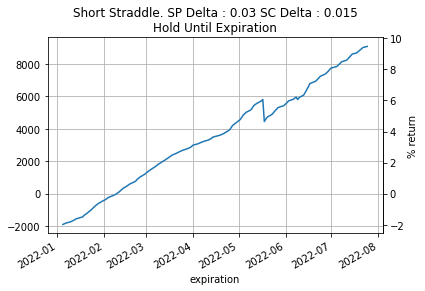

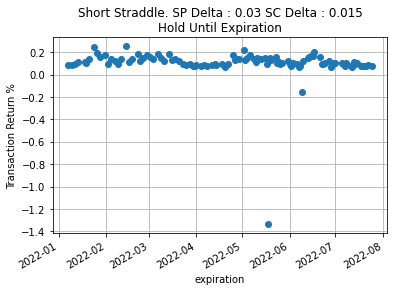

In [3]:
# ssshtes = StaticShortIronCondorHoldToExpStrategy(commission,1,purchase_time,0.12,0.12, 0.034, 0.033, df_ty, initial_portfolio_value, debug = True)
ssshtes = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,0.03,0.015, df_ty, initial_portfolio_value, debug = True)
sharp = ssshtes.evaluate(df)

In [4]:
def run_backtest(strat, df):
    return strat.evaluate(df)

In [5]:
def objective(trial, df, purchase_time):
    delta_sp_trial = trial.suggest_float("delta_sp", 0.002, 0.55)
#     delta_lp_trial = trial.suggest_float("delta_p_offset", 0.001, 0.5)
    delta_sc_trial = trial.suggest_float("delta_sc", 0.002, 0.55)
#     delta_lc_trial = trial.suggest_float("delta_c_offset", 0.001, 0.50)
#     max_loss = trial.suggest_float("max_loss", 1.25, 4.0)
   
    
    strategy = StaticShortStraddleHoldToExpStrategy(commission,1,purchase_time,delta_sp_trial,delta_sc_trial, df_ty, initial_portfolio_value)
    score = run_backtest(strategy, df)
    return score

In [6]:
study_name = "optimal-short-straddle-study_2021-2022_1DTE_1"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(direction = "maximize", study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(lambda trial: objective(trial, df, purchase_time), n_trials = 2)
trial = study.best_trial
print("Best Score: ", trial.value)
print("Best Params: ")
for key, value in trial.params.items():
    print("  {}: {}".format(key, value))

[I 2023-05-16 21:22:29,437] A new study created in RDB with name: optimal-short-straddle-study_2021-2022_1DTE_1
[I 2023-05-16 21:22:30,483] Trial 0 finished with value: 214.136 and parameters: {'delta_sp': 0.46564902146502124, 'delta_sc': 0.50686828774284}. Best is trial 0 with value: 214.136.
[I 2023-05-16 21:22:31,538] Trial 1 finished with value: -362.273 and parameters: {'delta_sp': 0.33107038370823433, 'delta_sc': 0.19351010313520675}. Best is trial 0 with value: 214.136.


Best Score:  214.136
Best Params: 
  delta_sc: 0.50686828774284
  delta_sp: 0.46564902146502124
